In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



In [5]:
from pyImagingMSpec import inMemoryIMS
file_in = '/Users/palmer/Documents/tmp_data/ClaireCarter_ratBrain/FixedTissue_leap8cyc_2-_10_08SET1(081020,16h25m).imzML'
ims_dataset = inMemoryIMS.inMemoryIMS(file_in, norm=[], spectrum_type='profile')

TODO: convert indices into real world coordinates
loaded spectra
file loaded


In [12]:
# Dimensionality reduction + PCA + clustering
import numpy as np
from scipy import interpolate
import pymf
def interp_spectrum(spec,mzaxis):
    mzs = spec.get_spectrum(source='profile')[0]
    ints = spec.get_spectrum(source='profile')[1]
    f = interpolate.interp1d(mzs, ints, fill_value=0, assume_sorted=True, bounds_error=False)
    return f(mzaxis)

def rp(ims_dataset,nRP=100,mz_axis=np.arange(100.,1000.,0.15)):
    nBins = len(mz_axis)
    nSpec = len(ims_dataset.coords)
    rpMatrix = np.random.randn(nRP,nBins)
    reducedData = np.zeros((nSpec,nRP))
    for n,ii in enumerate(ims_dataset.index_list):
        try:
            spec = ims_dataset.get_spectrum(ii)
            specBinned = interp_spectrum(spec,mz_axis)
            reducedData[ii,:] = np.dot(rpMatrix,specBinned)
            if n%1000==0:
                print("{:3.2f}".format(100.*n/len(ims_dataset.index_list))),
        except:
            print ii
            raise
    return reducedData
def project_images(projection,IMS_dataset):
    from pyImagingMSpec.ion_datacube import ion_datacube
    proj_im = ion_datacube()
    proj_im.coords = IMS_dataset.coords
    proj_im.pixel_indices = IMS_dataset.cube_pixel_indices
    proj_im.nRows = IMS_dataset.cube_n_row
    proj_im.nColumns = IMS_dataset.cube_n_col
    for ii in range(0,np.shape(projection)[1]):
        proj_im.add_xic(projection[:,ii], [ii], [0])
    return proj_im

def ba(ims_dataset, n_rp=100, mz_axis=np.arange(100.,1000.)):
    n_bins = len(mz_axis)
    n_spec = len(ims_dataset.index_list)
    rp_matrix = np.random.randn(n_spec, n_rp)
    reducedData = np.zeros((n_bins,n_rp))
    for n,ii in enumerate(ims_dataset.index_list):
        spec = ims_dataset.get_spectrum(ii)
        specBinned = interp_spectrum(spec,mz_axis)
        reducedData += specBinned.reshape(n_bins,1)*rp_matrix[ii,:]
        if n%1000==0:
            print("{:3.2f}".format(100.*n/len(ims_dataset.index_list))),
    print("\n")
    coeff = np.linalg.qr(reducedData, mode='reduced')[0]
    del reducedData
    coeff_dash = coeff.T
    proj = np.zeros((n_spec, n_rp))
    for n,ii in enumerate(ims_dataset.index_list):
        spec = ims_dataset.get_spectrum(ii)
        specBinned = interp_spectrum(spec,mz_axis)
        proj[ii,:] = np.dot(coeff_dash,specBinned)
        if n%1000==0:
            print("{:3.2f}".format(100.*n/len(ims_dataset.index_list))),
    print("\n")
    return coeff, proj

# Dimensionaly reduction w/ rp
mz_axis = np.arange(100.,1000., 0.05)
n_rp=100
coeff, reducedData = ba(ims_dataset, n_rp=n_rp, mz_axis=mz_axis)
print "coeff", np.shape(coeff), "proj", np.shape(reducedData)
 
# Try RP-PCA 
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(reducedData)
X = pca.transform(reducedData)
coeff_ = pca.transform(np.eye(n_rp))
print "PCAcoeff",np.shape(coeff_), "PCAproj", np.shape(X)

# Try S-NMF
n_snmf = 7
snmf_mdl = pymf.SNMF(reducedData.T, num_bases=n_snmf)
maxiter = 50
for ii in range(maxiter):
    snmf_mdl.factorize(niter=50)
    print("{} ".format(np.abs(snmf_mdl.ferr[-1] - snmf_mdl.ferr[-2])/snmf_mdl._num_samples))
    if snmf_mdl.converged(49):
        break
print snmf_mdl.converged(9)
print "SNMF:", np.shape(snmf_mdl.W), np.shape(snmf_mdl.H)

#Show projection vector images
c_map = plt.get_cmap('viridis')

# PCA
pca_ims = project_images(X,ims_dataset)



 0.00 4.87 9.74 14.61 19.48 24.35 29.22 34.09 38.96 43.83 48.70 53.57 58.44 63.31 68.18 73.05 77.92 82.79 87.66 92.52 97.39 

0.00 4.87 9.74 14.61 19.48 24.35 29.22 34.09 38.96 43.83 48.70 53.57 58.44 63.31 68.18 73.05 77.92 82.79 87.66 92.52 97.39 

coeff (18000, 100) proj (20535, 100)
PCAcoeff (100, 100) PCAproj (20535, 100)
0.0113126473841 
0.00629100901611 
0.00448870461023 
0.00437408137631 
0.00364791513878 
0.00200182621584 
0.00125311546034 
0.00102876948936 
0.000916537901466 
0.000764251772314 
0.000583592981848 
0.000419149711313 
0.000300509914558 
0.000225326844623 
0.000181034554527 
0.000156480805423 
0.000143748309854 
0.000137518164276 
0.000134586186929 
0.000131487796554 
0.000126749434774 
0.000119072394293 
0.00010856884793 
9.64869096557e-05 
8.42555666442e-05 
7.28989984704e-05 
6.28585125511e-05 
5.40910367999e-05 
4.66582189014e-05 
4.03448335045e-05 
3.50534271491e-05 
3.08346516154e-05 
2.74939169176e-05 
2.47317662304e-05 
2.23579377426e-05 
2.03571825886e-0

<IPython.core.display.Javascript object>


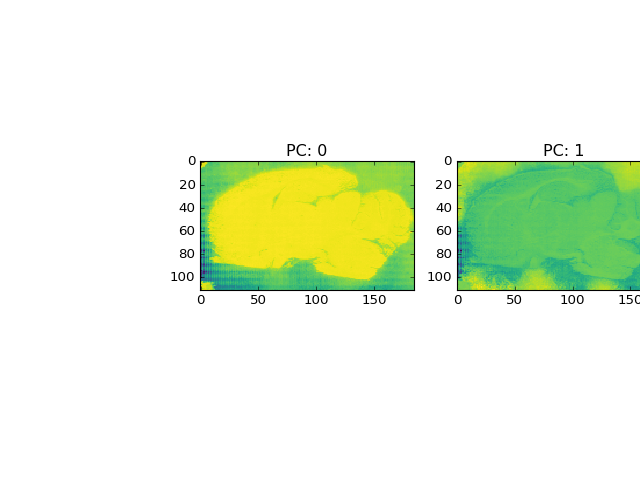

<IPython.core.display.Javascript object>


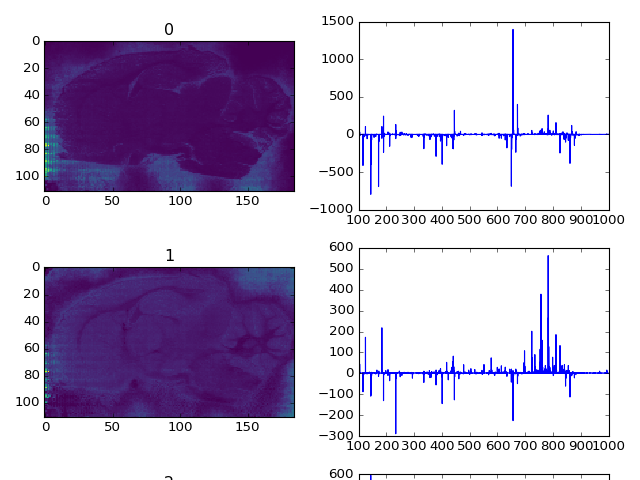

In [13]:
fig,ax = plt.subplots(2,5)
fig.set_figwidth(20)
fig.set_figheight(10)
for jj in range(0,2):
    for ii in range(0,5):
        im=pca_ims.xic_to_image(5*jj+ii)
        ax[jj,ii].imshow(np.rot90(im),cmap=c_map, interpolation='nearest')
        ax[jj,ii].set_title('PC: {}'.format(5*jj+ii))
plt.show()  

# SNMF
#plt.figure(figsize=(10,10))
#for ii in range(n_snmf):
#    plt.plot(mz_axis, np.dot(coeff,snmf_mdl.W[:,ii]))
#plt.show()
snmf_ims = project_images(snmf_mdl.H.T,ims_dataset)
fig,ax = plt.subplots(n_snmf,2)
#fig.set_figwidth(20)
fig.set_figheight(20)
for jj in range(0,n_snmf):
    for ii in range(2):
        if ii==0:
            im=snmf_ims.xic_to_image(jj)
            ax[jj,ii].imshow(np.rot90(im),cmap=c_map, interpolation='nearest')
            ax[jj,ii].set_title(jj)
        if ii==1:
            ax[jj,ii].plot(mz_axis, np.dot(coeff,snmf_mdl.W[:,jj]))
plt.tight_layout()
plt.show() 

<IPython.core.display.Javascript object>


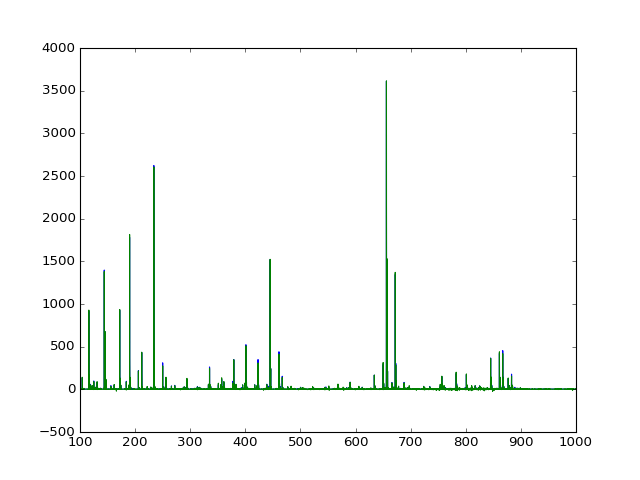

In [14]:
# Check BA worked
ix = 50
spec = ims_dataset.get_spectrum(ims_dataset.index_list[ix])
plt.figure()
plt.plot(mz_axis,interp_spectrum(spec,mz_axis))
plt.plot(mz_axis, np.dot(coeff,reducedData[ix,:]))
plt.show()

In [15]:
#Check nnmf sucess on reconstructing individual spectra
for ix in range(9):
    spec = ims_dataset.get_spectrum(ix)
    #plt.figure()
    #plt.plot(mz_axis,interp_spectrum(spec,mz_axis))
    #print np.shape(snmf_mdl.H)
    #for ix in range(9):
    #plt.plot(mz_axis, np.sum([snmf_mdl.H[ii][ix]*np.dot(coeff,snmf_mdl.W[:,ii])*(np.dot(coeff,snmf_mdl.W[:,ii])>=0) for ii in range(n_snmf)],axis=0))
    #plt.show()
    recon_gt0 = np.sum([snmf_mdl.H[ii][ix]*np.dot(coeff,snmf_mdl.W[:,ii])*(np.dot(coeff,snmf_mdl.W[:,ii])>=0) for ii in range(n_snmf)],axis=0)
    recon = np.sum([snmf_mdl.H[ii][ix]*np.dot(coeff,snmf_mdl.W[:,ii]) for ii in range(n_snmf)],axis=0)
    error = np.abs(1-(np.sum(abs(recon_gt0 - interp_spectrum(spec,mz_axis))) / np.sum(abs(recon - interp_spectrum(spec,mz_axis)))))
    error = np.mean(abs(recon - interp_spectrum(spec,mz_axis)))
    print error, np.sum(interp_spectrum(spec,mz_axis))


2.04728104092 42911.1477751
1.73826541413 34400.3298769
1.75883060281 35143.0544447
1.88742384664 39746.8968626
1.6546404415 56934.2554339
1.67658532826 32751.3851918
1.87423017269 47555.3576746
2.08135545731 107826.269681
2.72406915821 127654.961049


<IPython.core.display.Javascript object>


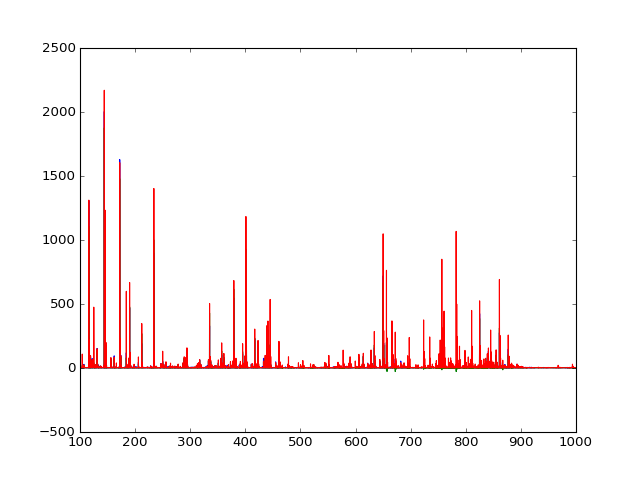

In [16]:
# View reconstruction quality on a spectrum
ix = 550
spec = ims_dataset.get_spectrum(ix)
recon = np.sum([snmf_mdl.H[ii][ix]*np.dot(coeff,snmf_mdl.W[:,ii]) for ii in range(n_snmf)],axis=0)
recon_gt0 = np.sum([snmf_mdl.H[ii][ix]*np.dot(coeff,snmf_mdl.W[:,ii])*(np.dot(coeff,snmf_mdl.W[:,ii])>=0) for ii in range(n_snmf)],axis=0)

plt.figure()
plt.plot(mz_axis, interp_spectrum(spec,mz_axis))
plt.plot(mz_axis, recon)
plt.plot(mz_axis, recon_gt0)
plt.show()

In [17]:
# find nearest sum formula to an mz using chemcalc
import urllib, urllib2
import json
import pandas as pd
from pyMSpec.pyisocalc import pyisocalc
def search_mz(mass,adducts, ppm_limit=25., charge_state=1):
    chemcalcURL = 'http://www.chemcalc.org/chemcalc/em'
    # Define a molecular formula string
    mfRange = ''.join(['C0-100','H0-100','N0-10','O0-10','P0-1'])
    # target mass
    # Chemcalc seems to take some rules into account when searching, so adduct mass must be removed
    best_hit={'adduct':'', 'ppm': 1000., 'sf':''}
    for adduct in adducts:
        mass_ = mass - pyisocalc.periodic_table[adduct][2][0]
        mass_ += pyisocalc.periodic_table['Ee'][2][0]*charge_state
        # Define the parameters and send them to Chemcalc
        # other options (mass tolerance, unsaturation, etc.
        params = {'mfRange': mfRange,'monoisotopicMass': mass_, 'massRange': ppm_limit*mass*1e-6}
        response = urllib2.urlopen(chemcalcURL, urllib.urlencode(params))

        # Read the output and convert it from JSON into a Python dictionary
        jsondata = response.read()
        data = json.loads(jsondata)
        if data['results']==[]:
            #print '{} nothing for {}'.format(mz, adduct)
            continue
        df = pd.DataFrame.from_dict(data['results'])
        df['ppm'] = df['ppm'].apply(abs)
        df.sort('ppm')
        if df.ix[0]['ppm'] < best_hit['ppm']:
            best_hit={'adduct':adduct, 'ppm': df.ix[0]['ppm'], 'sf':df.ix[0]['mf']}
    return best_hit

In [18]:
#C42H84NO7P
from pyMSpec import centroid_detection
def fit_spectrum(mz_axis, coeff_spec, ppm_t=5000, max_peaks=50):
    mzs_c, ints_c = centroid_detection.gradient(mz_axis, coeff_spec, min_intensity=0.1, max_output=10)[0:2]
    mzs_c = [mzs_c[ii] for ii in np.argsort(ints_c)]
    ints_c = [ints_c[ii] for ii in np.argsort(ints_c)]

    sf_list = []
    while not mzs_c == []:
        mz = mzs_c.pop()
        v  = ints_c.pop()
        best_hit = search_mz(mz,['H','Na','K'])
        if best_hit['sf']=='':
            print 'no hits for {}'.format(mz)
            continue
        sf_list.append([v,best_hit])
        theor_spec = pyisocalc.complete_isodist(pyisocalc.parseSumFormula("{}+{}".format(best_hit['sf'],best_hit['adduct'])),sigma=0.1,charge=1)
        for mz_ in theor_spec.get_spectrum(source='centroids')[0]:
            keep_list = np.where(1e6*np.abs(mzs_c-mz_)/mz_ > ppm_t)[0]
        mzs_c  = [mzs_c[ii] for ii in keep_list]
        ints_c = [ints_c[ii] for ii in keep_list]
        print len(sf_list)
        if len(sf_list)>=max_peaks:
            return sf_list
    return sf_list

spec_fit = []
for ii in range(n_snmf):
    print "coeff", ii
    coeff_spec = np.dot(coeff,snmf_mdl.W[:,ii])
    spec_fit.append(fit_spectrum(mz_axis, coeff_spec))

coeff 0
1
2
3
4
no hits for 188.929703319
5
6
7
8
coeff 1
1
2
3
4
5
6
7
coeff 2
1
2
3
4
5
6
7
no hits for 189.845211727
8
coeff 3
1
2
3
4
5
6
7
8
coeff 4
1
2
3
4
5
6
7
coeff 5
1
2
3
4
5
6
7
8
coeff 6
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


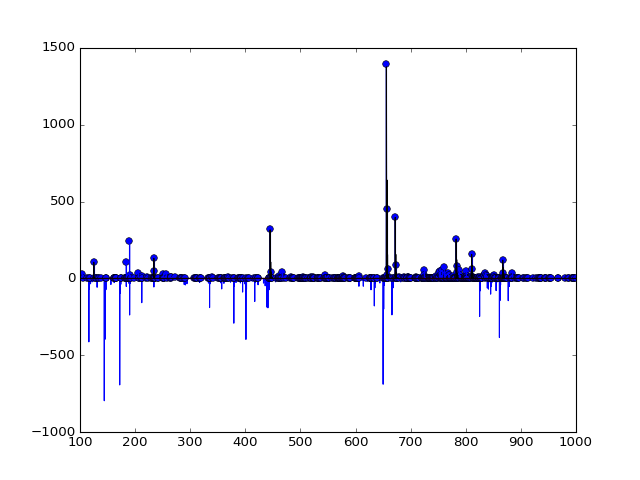

<IPython.core.display.Javascript object>


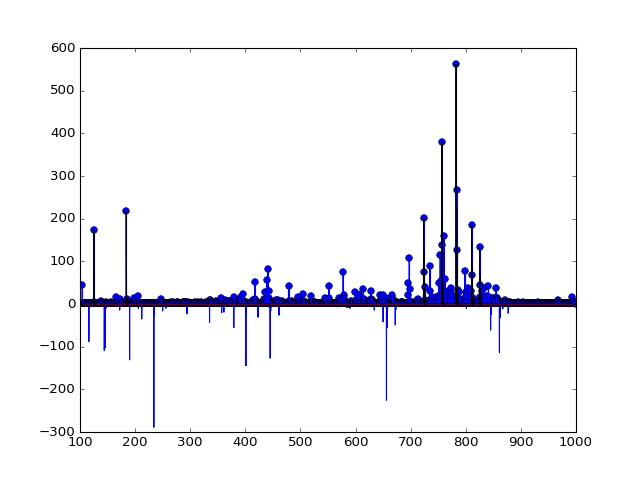

<IPython.core.display.Javascript object>


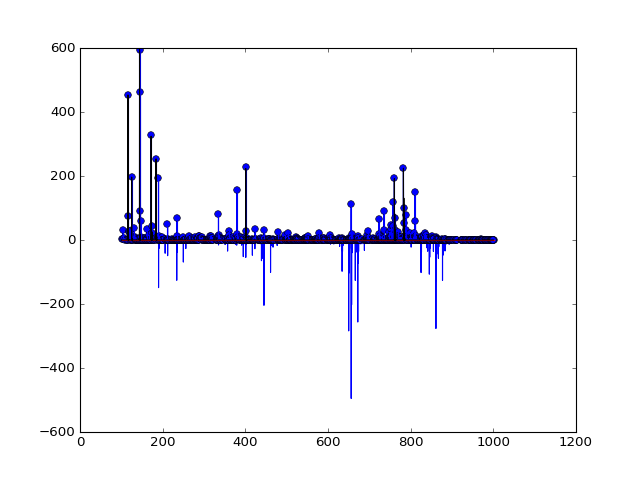

<IPython.core.display.Javascript object>


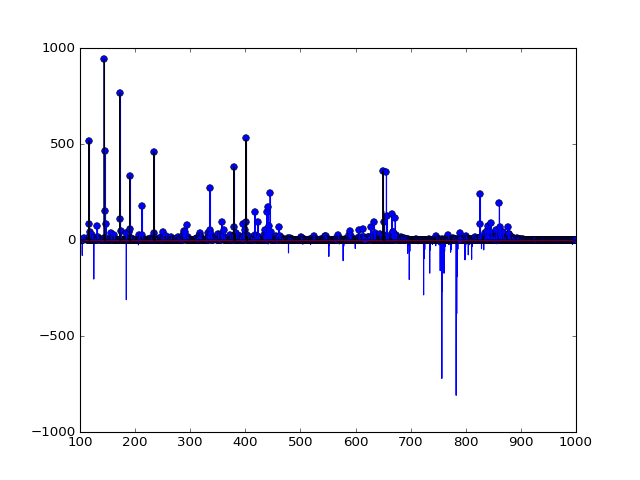

<IPython.core.display.Javascript object>


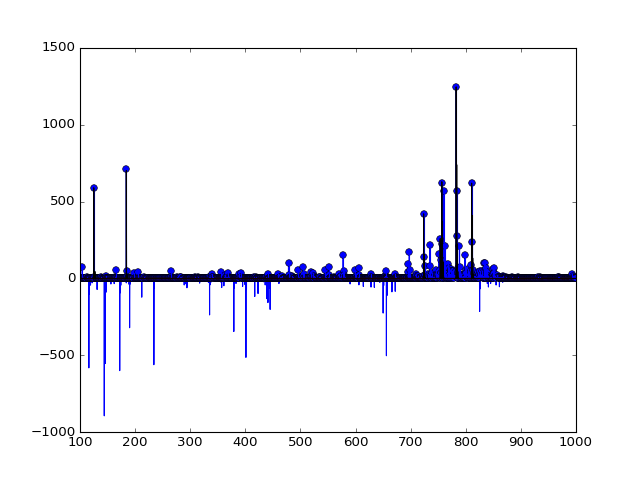

<IPython.core.display.Javascript object>


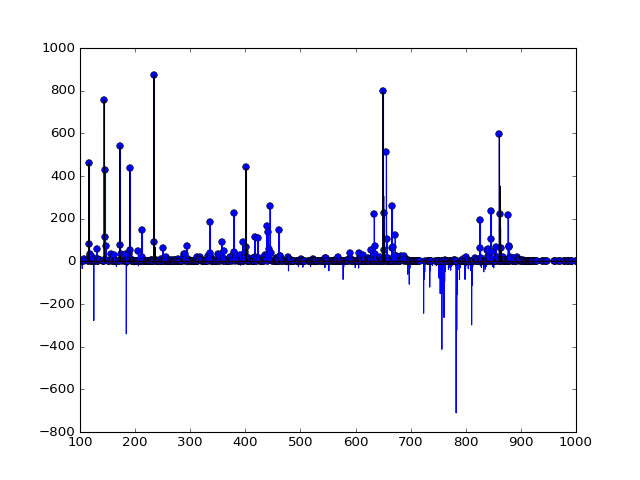

<IPython.core.display.Javascript object>


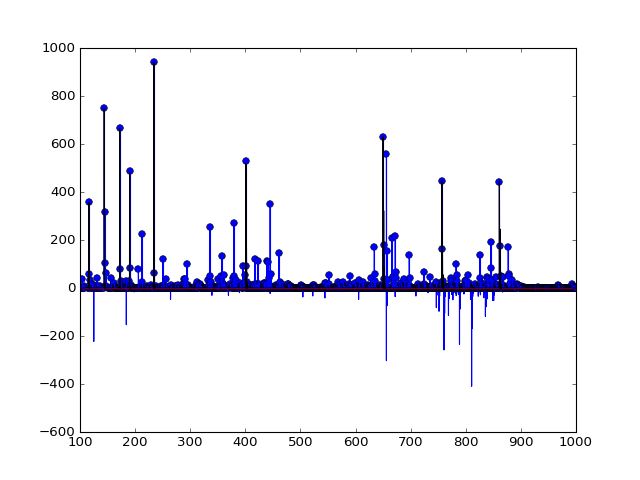

In [19]:
for ii in range(n_snmf):
    sf_list=spec_fit[ii]
    coeff_spec = np.dot(coeff,snmf_mdl.W[:,ii])
    mzs_c, ints_c = centroid_detection.gradient(mz_axis, coeff_spec, min_intensity=0.1)[0:2]
    plt.figure()
    plt.plot(mz_axis, coeff_spec)
    plt.stem(mzs_c,ints_c)
    ints = np.zeros(mz_axis.shape)
    for hit in sf_list:
        v = hit[0]
        best_hit=hit[1]
        theor_spec = pyisocalc.complete_isodist(pyisocalc.parseSumFormula("{}+{}".format(best_hit['sf'],best_hit['adduct'])),charge=1,sigma=0.1).get_spectrum(source='profile')
        f = interpolate.interp1d(theor_spec[0],v*theor_spec[1]/max(theor_spec[1]), fill_value=0, assume_sorted=True, bounds_error=False)
        ints += f(mz_axis)
                                 
    plt.plot(mz_axis, ints,color='black')

In [20]:
from collections import OrderedDict
layers = {}
layers['layers_list'] = OrderedDict()
for ii in range(n_snmf):
    layers['layers_list'][ii] = {}
    layers['layers_list'][ii]['image'] = snmf_ims.xic_to_image(jj)
    layers['layers_list'][ii]['sf_list'] = []
    for sf in sf_list:
        sf_a = "{}+{}".format(sf[1]['sf'], sf[1]['adduct'])
        iso_pattern = pyisocalc.perfect_pattern(pyisocalc.parseSumFormula(sf_a),charge=1).get_spectrum(source='centroids')
        mult = [sf[0],]
        layers['layers_list'][ii]['sf_list'].append({"sf_a":sf_a,"iso_pattern":(iso_pattern[0],iso_pattern[1]/100.),"mult":mult})

In [ ]:
#print layers['layers_list'][ii]['sf_list']

In [23]:
ms_info = {}
ms_info["min_mz"] = 100
ms_info["max_mz"] = 1000
ms_info["n_samples"] = 2.5e6
ms_info["sample_scale_factor"] = 0.9
ms_info["noise_factor"] = 1
ms_info["ppm_accuracy"] = 0.25
ms_info["ms_type"] = 'orbitrap'
ms_info["cent_kwargs"] = {}

In [27]:
import sys
sys.path.append('/Users/palmer/Documents/python_codebase/')
from pyims_simulate_evaluate import simulate
output_file = 'test.imzML'
s = simulate.sim_data(output_file,layers,ms_info)
s.simulate_dataset(mode='profile')
print "done"
spec = s.generate_spectrum(10,10,mode='profile')
plt.figure()
plt.plot(spec[0],spec[1])
plt.show()


0
1
2


KeyboardInterrupt: 

In [ ]:
from pyImagingMSpec.inMemoryIMS import inMemoryIMS
sim_dataset=inMemoryIMS(output_file, norm=[])

In [ ]:
mean_spec = ims_dataset.generate_summary_spectrum(ppm=600)
mean_spec_sim = sim_dataset.generate_summary_spectrum(ppm=50)
plt.figure()
plt.plot(mean_spec[0],mean_spec[1])
plt.plot(mean_spec_sim[0],mean_spec_sim[1])
plt.show()


In [ ]:
mz = np.asarray([715.539,])
ppm=500.0

tic_image = ims_dataset.get_summary_image()
tic_image_sim = sim_dataset.get_summary_image()
ion_im = ims_dataset.get_ion_image(mz,ppm)
ion_im_sim = sim_dataset.get_ion_image(mz,ppm)

plt.figure()
plt.imshow(ion_im.xic_to_image(0), interpolation='nearest')
plt.show()
plt.figure()
plt.imshow(ion_im_sim.xic_to_image(0), interpolation='nearest')
plt.show()